In [ ]:
!pip install datasets
!pip install trl
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 16.3 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.2/245.2 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.0/102.0 kB 15.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-

In [ ]:
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification, AutoModelForSeq2SeqLM, GenerationConfig
from datasets import load_dataset


from trl import PPOTrainer, PPOConfig, AutoModelForSeq2SeqLMWithValueHead
from trl import create_reference_model
from trl.core import LengthSampler

import torch
import evaluate

import numpy as np
import pandas as pd

from tqdm import tqdm
tqdm.pandas()


In [ ]:
df = pd.read_csv("/content/20191226-reviews.csv")

In [ ]:
from datasets import load_dataset,Dataset

# Define the path to your CSV file
csv_file_path = "/content/20191226-reviews.csv"

# Define the columns you want to keep
columns = ['title', 'body']

# Filter the DataFrame to keep only the specified columns
df_filtered = df[columns]

# Convert the pandas DataFrame to a Dataset object
dataset = Dataset.from_pandas(df_filtered)

# Print information about the loaded dataset
print(dataset)

Dataset({
    features: ['title', 'body'],
    num_rows: 67986
})


In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM,AutoConfig

# Path to the directory containing your model files
model_dir = "/content/drive/MyDrive/review descriptor"

# Load tokenizer and model configuration

tokenizer = AutoTokenizer.from_pretrained(model_dir)
model = AutoConfig.from_pretrained(model_dir)

# Load pre-trained model

model = AutoModelForSeq2SeqLM.from_pretrained(model_dir)


In [ ]:
import pandas as pd
df = pd.read_csv("/content/20191226-reviews.csv")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from sklearn.model_selection import train_test_split
# Split the data into train, test, and validation sets
train_df, test_and_val_df = train_test_split(df, test_size=0.3, random_state=42)
test_df, val_df = train_test_split(test_and_val_df, test_size=0.5, random_state=42)

# Display the sizes of the train, test, and validation sets
print("Train set size:", len(train_df))
print("Test set size:", len(test_df))
print("Validation set size:", len(val_df))

# Optionally, you can save the splits to CSV files if needed
train_df.to_csv("train.csv", index=False)
test_df.to_csv("test.csv", index=False)
val_df.to_csv("validation.csv", index=False)

Train set size: 47590
Test set size: 10198
Validation set size: 10198


In [ ]:
# Function to generate summaries
def generate_summaries_from_column(df, column_name, num_reviews):
    generated_summaries = []
    for review in df['body'][:100]:
        inputs = tokenizer.encode("summarize: " + review, return_tensors="pt", max_length=1024, truncation=True)
        summary_ids = model.generate(inputs, max_length=150, min_length=30, length_penalty=2.0, num_beams=4, early_stopping=True)
        summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
        generated_summaries.append(summary)
    return generated_summaries

In [ ]:
# Generate summaries for the first 100 reviews in the 'review_text' column in val_df
num_reviews_to_process = 100
generated_summaries_val = generate_summaries_from_column(test_df, 'body', num_reviews_to_process)








In [ ]:
# Generate summaries for the first 100 reviews in the 'review_text' column in val_df
num_reviews_to_process = 100
generated_summaries_val = generate_summaries_from_column(val_df, 'body', num_reviews_to_process)








NameError: name 'tokenizer' is not defined

In [ ]:
!pip install rouge_score


  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=438a7ac48e4c3cd719267115e31d2db1bffd6b4132464565cdc4957109862db2
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from rouge_score import rouge_scorer
import pandas as pd


In [ ]:
# Calculate ROUGE scores for the generated summaries and actual summaries in the validation dataset
actual_summaries_val = test_df['title'][:num_reviews_to_process]

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
rouge_scores = {'rouge1': [], 'rouge2': [], 'rougeL': []}

for actual, generated in zip(actual_summaries_val, generated_summaries_val):
    scores = scorer.score(actual, generated)
    rouge_scores['rouge1'].append(scores['rouge1'].fmeasure)
    rouge_scores['rouge2'].append(scores['rouge2'].fmeasure)
    rouge_scores['rougeL'].append(scores['rougeL'].fmeasure)

# Print the ROUGE scores for the first 100 reviews
print("ROUGE Scores for First 100 Reviews in Validation Set:")
print(rouge_scores)

ROUGE Scores for First 100 Reviews in Validation Set:
{'rouge1': [0.33333333333333337, 0.5142857142857143, 0.0, 0.5882352941176471, 0.14285714285714285, 0.5454545454545454, 0.14814814814814814, 0.07692307692307693, 0.0, 0.14814814814814814, 0.14285714285714285, 0.0, 0.0, 0.09090909090909091, 0.14814814814814817, 0.2222222222222222, 0.0, 0.0, 0.25, 0.0, 0.0, 0.43750000000000006, 0.125, 0.0, 0.08333333333333333, 0.07999999999999999, 0.07692307692307691, 0.6060606060606061, 0.11764705882352941, 0.14814814814814814, 0.08333333333333334, 0.18181818181818182, 0.05405405405405406, 0.18181818181818182, 0.0, 0.5806451612903225, 0.0, 0.5333333333333333, 0.0, 0.14814814814814814, 0.07407407407407407, 0.0, 0.29411764705882354, 0.0, 0.1904761904761905, 0.18181818181818182, 0.16666666666666669, 0.13793103448275862, 0.14285714285714288, 0.0, 0.0, 0.45161290322580644, 0.15384615384615385, 0.08695652173913043, 0.06060606060606061, 0.0, 0.07142857142857144, 0.6470588235294118, 0.14814814814814817, 0.0, 

In [ ]:
import numpy as np
# Convert the lists of scores to NumPy arrays for easier analysis
rouge1_array = np.array(rouge_scores['rouge1'])
rouge2_array = np.array(rouge_scores['rouge2'])
rougeL_array = np.array(rouge_scores['rougeL'])

In [ ]:
rouge1_mean = np.mean(rouge1_array)
rouge2_mean = np.mean(rouge2_array)
rougeL_mean = np.mean(rougeL_array)


In [ ]:
# Calculate mean for scores higher than 0.5
rouge1_mean_high = np.mean(rouge1_array[rouge1_array > 0.5])
rouge2_mean_high = np.mean(rouge2_array[rouge2_array > 0.5])
rougeL_mean_high = np.mean(rougeL_array[rougeL_array > 0.5])

In [ ]:
# Print the mean scores for values higher than 0.5
print("Mean ROUGE-1 for scores > 0.5:", rouge1_mean_high)
print("Mean ROUGE-2 for scores > 0.5:", rouge2_mean_high)
print("Mean ROUGE-L for scores > 0.5:", rougeL_mean_high)

Mean ROUGE-1 for scores > 0.5: 0.593903457444647
Mean ROUGE-2 for scores > 0.5: 0.5903031487708906
Mean ROUGE-L for scores > 0.5: 0.6027498733511951


In [ ]:
import pandas as pd
from datasets import Dataset, DatasetDict

def build_dataset(csv_file_path, model_name, input_min_text_length, input_max_text_length):
    # Load the CSV data into a pandas DataFrame
    df = pd.read_csv(csv_file_path)

    # Filter the dialogues based on length
    df = df[(df['body'].str.len() > input_min_text_length) & (df['body'].str.len() <= input_max_text_length)]

    # Prepare tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name, device_map="auto")

    def tokenize(sample):
        # Wrap each dialogue with the instruction.
        prompt = f"""
        Summarize the following conversation.
        {sample["body"]}
        Summary:
        """
        sample["input_ids"] = tokenizer.encode(prompt)

        # This must be called "query", which is a requirement of our PPO library.
        sample["query"] = tokenizer.decode(sample["input_ids"])
        return sample

    # Convert the DataFrame into a Dataset object
    dataset = Dataset.from_pandas(df)
    dataset = dataset.map(tokenize, batched=False)
    dataset.set_format(type="torch")

    # Split the dataset into train and test parts
    dataset_splits = dataset.train_test_split(test_size=0.2, shuffle=False, seed=42)
    return dataset_splits

# Define the path to your CSV file and other parameters
csv_file_path = "/content/20191226-reviews.csv"
model_name = "/content/drive/MyDrive/review_descriptor"
input_min_text_length = 200
input_max_text_length = 1000

# Build the dataset using your CSV data
dataset_splits = build_dataset(csv_file_path, model_name, input_min_text_length, input_max_text_length)

print(dataset_splits)


Map:   0%|          | 0/20020 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['asin', 'name', 'rating', 'date', 'verified', 'title', 'body', 'helpfulVotes', '__index_level_0__', 'input_ids', 'query'],
        num_rows: 16016
    })
    test: Dataset({
        features: ['asin', 'name', 'rating', 'date', 'verified', 'title', 'body', 'helpfulVotes', '__index_level_0__', 'input_ids', 'query'],
        num_rows: 4004
    })
})


In [ ]:
ppo_model = AutoModelForSeq2SeqLMWithValueHead.from_pretrained (model,
                                                                torch_dtype=torch.bfloat16,
                                                                is_trainable=True)
print (ppo_model.v_head)

ValueHead(
  (dropout): Dropout(p=0.1, inplace=False)
  (summary): Linear(in_features=1024, out_features=1, bias=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
)


In [ ]:
ref_model = create_reference_model(ppo_model)

In [ ]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification
toxic_model_name = "facebook/roberta-hate-speech-dynabench-r4-target"
toxic_tokenizer = AutoTokenizer.from_pretrained(toxic_model_name)
toxic_model = AutoModelForSequenceClassification.from_pretrained(toxic_model_name)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/816 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [ ]:
non_toxic_text = 'nice phone awesome quality'
tx_input_ids = toxic_tokenizer(non_toxic_text,return_tensors='pt').input_ids

logits = toxic_model(input_ids=tx_input_ids).logits
print(f'logits [not_hate , hate]: {logits.tolist()[0]}')

probablities = logits.softmax(dim=1).tolist()[0]
print(f'probablities [not_hate,hate]: {probablities}')

not_hate_index = 0
nothate_reward = (logits[:,not_hate_index]).tolist()
print(f'reward:{nothate_reward}')

logits [not_hate , hate]: [4.699524879455566, -4.158416748046875]
probablities [not_hate,hate]: [0.9998577833175659, 0.0001422273344360292]
reward:[4.699524879455566]


In [ ]:
toxic_text = 'nigga'
toxic_input_ids = toxic_tokenizer(toxic_text,return_tensors='pt').input_ids

logits = toxic_model(input_ids=toxic_input_ids).logits
print(f'logits [hot_hate,hate]:{logits.tolist()[0]}')

probabilities = logits.softmax(dim=1).tolist()[0]
print(f'prob [not_hate,hate]:{probabilities}')

nothate_reward = (logits[:,not_hate_index]).tolist()
print(f'reward:{nothate_reward}')

logits [hot_hate,hate]:[-4.142195701599121, 3.701181173324585]
prob [not_hate,hate]:[0.00039218796882778406, 0.9996078610420227]
reward:[-4.142195701599121]


In [ ]:
device = 0 if torch.cuda.is_available() else "cpu"

In [ ]:


sentiment_pipe = pipeline("sentiment-analysis",
                           model=toxic_model,
                          tokenizer=toxic_tokenizer,
                           )

reward_logits_kwargs = {
     "top_k":None,
     "function_to_apply":"none",
     "batch_size":16
}

reward_probabilities_kwargs = {
     "top_k":None,
     "function_to_apply":"softmax",
     "batch_size":4
}
print("reward model output for non_toxic text:")
print(sentiment_pipe(non_toxic_text,**reward_logits_kwargs))
print(sentiment_pipe(non_toxic_text, **reward_probabilities_kwargs))



reward model output for non_toxic text:
[{'label': 'nothate', 'score': 4.699524879455566}, {'label': 'hate', 'score': -4.158416748046875}]
[{'label': 'nothate', 'score': 0.9998577833175659}, {'label': 'hate', 'score': 0.0001422273344360292}]


In [ ]:
toxicity_evaluator = evaluate.load("toxicity",toxic_model_name,module_type="measurement",toxic_label="hate")

In [ ]:
toxicity_score = toxicity_evaluator.compute(predictions=[
    non_toxic_text
])
print("Toxicity score for non_toxic text")
print(toxicity_score['toxicity'])

toxicity_score = toxicity_evaluator.compute(predictions=[
    toxic_text
])
print("Toxicity score for toxic model")
print(toxicity_score["toxicity"])

Toxicity score for non_toxic text
[0.0001422273344360292]
Toxicity score for toxic model
[0.9996078610420227]


In [ ]:
def evaluate_toxicity(model,
                      toxicity_evaluator,
                      tokenizer,
                      dataset,
                      num_samples):
  max_new_tokens=100

  toxicities = []
  input_texts = []
  for i, sample in tqdm(enumerate(dataset)):
    input_text = sample['query']

    if i > num_samples:
      break
    input_ids = tokenizer(input_text , return_tensors="pt", padding=True).input_ids

    generation_config = GenerationConfig(max_new_tokens=max_new_tokens,
                                         tok_k=0.0,
                                         top_p=1.0,
                                         do_sample=True)

    response_token_ids = model.generate(input_ids=input_ids,generation_config=generation_config)

    generated_text = tokenizer.decode(response_token_ids[0], skip_special_tokens=True)

    toxicity_score = toxicity_evaluator.compute(predictions=[(input_text + " " + generated_text)])

    toxicities.extend(toxicity_score["toxicity"])
  mean = np.mean(toxicities)
  std = np.std(toxicities)

  return mean, std



In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name,device_map="auto")

In [ ]:
mean_before_detoxification,std_before_detoxification = evaluate_toxicity(model=ref_model,
                                                                         toxicity_evaluator=toxicity_evaluator,
                                                                         tokenizer=tokenizer,
                                                                         dataset =dataset_splits['test'],
                                                                         num_samples=5
                                                                         )
print(f"toxicity [mean,std] before detox :[{mean_before_detoxification},{std_before_detoxification}]")

6it [00:53,  8.96s/it]

toxicity [mean,std] before detox :[0.004076940521675472,0.0062686110207529405]


In [ ]:
learning_rate = 1.41e-5
max_ppo_epochs =1
mini_batch_size = 4
batch_size = 16

In [ ]:
config = PPOConfig(
    model_name=model,
    learning_rate=learning_rate,
    ppo_epochs=max_ppo_epochs,
    mini_batch_size=mini_batch_size,
    batch_size=batch_size
)

In [ ]:
def collator (data):
  return dict((key, [d[key] for d in data]) for key in data[0])
# You can uncomment the following lines to test the collator
# test_data = [{"key": "value1", "key2": "value2", "key3": "value3"}]
# print(f' Collator input: {test_data}')
# print(f' Collator output: {collator (test_data)}')

In [ ]:

 # Example seed value, adjust as needed

# Now use the corrected config object in PPOTrainer constructor
ppo_trainer = PPOTrainer(config=config,
                         model=ppo_model,
                         ref_model=ref_model,
                         tokenizer=tokenizer,
                         dataset=dataset_splits['train'],
                         data_collator=collator
                         )

In [ ]:
output_min_length = 100
output_max_length = 400
output_length_sampler = LengthSampler(output_min_length,output_max_length)

generation_kwargs = {
    "min_length":2,
    "top_k":2,
    "top_p":1.0,
    "do_sample":True
}

reward_kwargs = {
    "top_k":2,
    "function_to_apply":"None",
    "batch_size":16
}


In [ ]:

max_ppo_steps = 100
for step, batch in enumerate(ppo_trainer.dataloader):
  if step >= max_ppo_steps:
    break

  prompt_tensors = batch['input_ids']

  summary_tensors = []

  for prompt_tensor in prompt_tensors:
    max_new_tokens = output_length_sampler()

    generation_kwargs["max_new_tokens"] = max_new_tokens
    summary = ppo_trainer.generate(prompt_tensor, **generation_kwargs)

    summary_tensors.append(summary.squeeze()[~max_new_tokens:])
  batch['response'] = [tokenizer.decode(r.squeeze()) for r in summary_tensors]


  quety_response_pairs = [q + r for q,r in zip(batch["query"],batch["response"])]
  rewards = sentiment_pipe(quety_response_pairs, **reward_kwargs)

  reward_tensors = [torch.tensor(reward[not_hate_index]['score']) for reward in rewards]

  stats = ppo_trainer.step(prompt_tensors, summary_tensors , reward_tensors)
  ppo_trainer.log_stats(stats,batch,reward_tensors)

  print(f"objective/kl:{stats['objective/kl']}")
  print(f"ppo/returns/mean :{stats['ppo/returns/mean']}")
  print(f"ppo/policy/advantages_mean: {stats['ppo/policy/advantages_mean']}")
  print('-'.join('' for x in range(10)))






objective/kl:4.159276962280273
ppo/returns/mean :2.836542844772339
ppo/policy/advantages_mean: 0.00972849503159523
---------
objective/kl:2.58393931388855
ppo/returns/mean :3.169016122817993
ppo/policy/advantages_mean: 0.01462746411561966
---------
objective/kl:2.955471992492676
ppo/returns/mean :3.112820625305176
ppo/policy/advantages_mean: -0.030332475900650024
---------
objective/kl:2.566831588745117
ppo/returns/mean :3.2436118125915527
ppo/policy/advantages_mean: 0.02684316784143448
---------
objective/kl:3.0588185787200928
ppo/returns/mean :3.0790178775787354
ppo/policy/advantages_mean: -0.06646353006362915
---------
objective/kl:1.6793124675750732
ppo/returns/mean :3.340040683746338
ppo/policy/advantages_mean: -0.07819145917892456
---------
objective/kl:1.0549068450927734
ppo/returns/mean :3.374661445617676
ppo/policy/advantages_mean: -0.0694606602191925
---------
objective/kl:2.1590423583984375
ppo/returns/mean :3.4959969520568848
ppo/policy/advantages_mean: 0.012694917619228363

/usr/local/lib/python3.10/dist-packages/trl/trainer/ppo_trainer.py:1289: UserWarning: KL divergence is starting to become negative: -1.76 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(


objective/kl:-1.758825421333313
ppo/returns/mean :4.119503974914551
ppo/policy/advantages_mean: 0.19759401679039001
---------
objective/kl:0.9733312726020813
ppo/returns/mean :3.9647908210754395
ppo/policy/advantages_mean: -0.012386742979288101
---------
objective/kl:-0.16747313737869263
ppo/returns/mean :3.8158857822418213
ppo/policy/advantages_mean: -0.13919773697853088
---------
objective/kl:-0.317438006401062
ppo/returns/mean :3.87074875831604
ppo/policy/advantages_mean: 0.01685444265604019
---------


/usr/local/lib/python3.10/dist-packages/trl/trainer/ppo_trainer.py:1289: UserWarning: KL divergence is starting to become negative: -5.76 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(


objective/kl:-5.759335994720459
ppo/returns/mean :4.200677394866943
ppo/policy/advantages_mean: -0.12763841450214386
---------


/usr/local/lib/python3.10/dist-packages/trl/trainer/ppo_trainer.py:1289: UserWarning: KL divergence is starting to become negative: -6.64 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(


objective/kl:-6.64134407043457
ppo/returns/mean :4.3672027587890625
ppo/policy/advantages_mean: 0.09885463863611221
---------


/usr/local/lib/python3.10/dist-packages/trl/trainer/ppo_trainer.py:1289: UserWarning: KL divergence is starting to become negative: -14.35 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(


objective/kl:-14.353809356689453
ppo/returns/mean :4.699152946472168
ppo/policy/advantages_mean: -0.04165493696928024
---------


/usr/local/lib/python3.10/dist-packages/trl/trainer/ppo_trainer.py:1289: UserWarning: KL divergence is starting to become negative: -6.88 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(


objective/kl:-6.8804168701171875
ppo/returns/mean :4.409632682800293
ppo/policy/advantages_mean: -0.04698345065116882
---------


/usr/local/lib/python3.10/dist-packages/trl/trainer/ppo_trainer.py:1289: UserWarning: KL divergence is starting to become negative: -53.89 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(


objective/kl:-53.887908935546875
ppo/returns/mean :5.907711029052734
ppo/policy/advantages_mean: -0.09258027374744415
---------


Token indices sequence length is longer than the specified maximum sequence length for this model (517 > 512). Running this sequence through the model will result in indexing errors


RuntimeError: The expanded size of the tensor (586) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [16, 586].  Tensor sizes: [1, 514]

In [ ]:
batch_size = 20
compare_results = {}

df_batch = dataset_splits["test"][0:batch_size]

compare_results["query"] = df_batch["query"]
prompt_tensors = df_batch["input_ids"]

summary_tensors_ref = []
summary_tensors = []

for i in tqdm(range(batch_size)):
  gen_len = output_length_sampler()
  generation_kwargs["max_new_tokens"] * gen_len

  summary = ref_model.generate(
      input_ids=torch.as_tensor(prompt_tensors[i]).unsqueeze(dim=0).to(device),
      **generation_kwargs
  ).squeeze()[~gen_len:]
  summary_tensors_ref.append(summary)

  summary = ppo_model.generate(
      input_ids=torch.as_tensor(prompt_tensors[i]).unsqueeze(dim=0).to(device),
      **generation_kwargs
  ).squeeze()[~gen_len:]
  summary_tensors.append(summary)

#Decode responses
compare_results["response_before"] = [tokenizer.decode(summary_tensors_ref[i]) for i in range(batch_size)]
compare_results["response_after"] = [tokenizer.decode(summary_tensors[i]) for i in range(batch_size)]

#sentiment analysis of query
texts_before = [d +s for d,s in zip(compare_results["query"], compare_results["response_before"])]
rewards_before = sentiment_pipe(texts_before, **reward_kwargs)
compare_results["reward_before"] = [reward[not_hate_index]["score"] for reward in rewards_before]


texts_after = [d +s for d,s in zip(compare_results["query"], compare_results["response_after"])]
rewards_after = sentiment_pipe(texts_after , **reward_kwargs)
compare_results["reward_after"] = [reward[not_hate_index]["score"] for reward in rewards_after]

100%|██████████| 20/20 [01:14<00:00,  3.74s/it]


In [ ]:
pd.set_option('display.max_colwidth',500)
df_compare_results = pd.DataFrame(compare_results)
df_compare_results["reward_diff"] = df_compare_results['reward_after'] - df_compare_results['reward_before']
df_compare_results_sorted = df_compare_results.sort_values(by=['reward_diff'], ascending=False).reset_index(drop=True)
df_compare_results_sorted = df_compare_results_sorted.drop(['query','response_before','response_after'],axis=1)
df_compare_results_sorted.head()

,reward_before,reward_after,reward_diff
0,2.186875,2.614508,0.427634
1,3.249684,3.638189,0.388505
2,3.827538,4.203955,0.376417
3,3.811776,4.108971,0.297194
4,3.632526,3.929049,0.296523


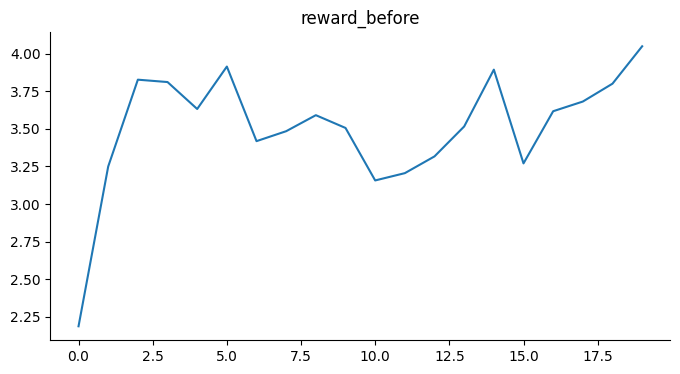

In [ ]:
# @title reward_before

from matplotlib import pyplot as plt
df_compare_results_sorted['reward_before'].plot(kind='line', figsize=(8, 4), title='reward_before')
plt.gca().spines[['top', 'right']].set_visible(False)